In [3]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

def summary(ndarr):
    print(ndarr)
    print("* shape: {}".format(ndarr.shape))
    print("* min: {}".format(np.min(ndarr)))
    print("* max: {}".format(np.max(ndarr)))
    print("* avg: {}".format(np.mean(ndarr)))
    print("* std: {}".format(np.std(ndarr)))
    print("* unique: {}".format(np.unique(ndarr)))

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

train_data = mnist.train
valid_data = mnist.validation
test_data = mnist.test

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [8]:
def plot_fatten_img(ndarr):
    img = ndarr.copy()
    img.shape = (28,28)
    plt.imshow(img, cmap='gray')
    plt.show()

In [21]:
class Autoencoder(object):
    def __init__(self,n_features,learning_rate=0.5,n_hidden=[128,64],alpha=0.0):
        self.n_features = n_features
        
        self.weights = None
        self.biases = None
        
        self.graph = tf.Graph() # initialize new grap
        self.build(n_features,learning_rate,n_hidden,alpha) # building graph
        self.sess = tf.Session(graph=self.graph) # create session by the graph 
        
    def build(self,n_features,learning_rate,n_hidden,alpha):
        with self.graph.as_default():
            ### Input
            self.train_features = tf.placeholder(tf.float32, shape=(None,n_features))

            ### Optimalization
            # build neurel network structure and get their predictions and loss
            self.y_,self.original_loss = self.structure(features=self.train_features,
                                                        n_hidden=n_hidden)
            
            # regularization loss
            self.regularization = tf.reduce_mean(
                                   [tf.nn.l2_loss(w)/tf.size(w,out_type=tf.float32)
                                        for w in self.weights.values()])
            # total loss
            self.loss = self.original_loss + alpha * self.regularization
            
            # define training operation
            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(self.loss)
            
            ### Prediction
            self.new_features = tf.placeholder(tf.float32, shape=(None,n_features))
            self.new_y_,self.new_loss = self.structure(features=self.new_features,
                                                        n_hidden=n_hidden)     
            
            ### Initialization
            self.init_op = tf.global_variables_initializer()  
    
    def structure(self,features,n_hidden):
        ### Variable
        if (not self.weights) and (not self.biases):
            self.weights = {
                'encode1': tf.Variable(tf.truncated_normal(
                    shape=(self.n_features,n_hidden[0]))), 
                'encode2': tf.Variable(tf.truncated_normal(
                    shape=(n_hidden[0],n_hidden[1]))),
                'decode1': tf.Variable(tf.truncated_normal(
                    shape=(n_hidden[1],n_hidden[0]))),
                'decode2': tf.Variable(tf.truncated_normal(
                    shape=(n_hidden[0],self.n_features))),    
            }
            self.biases  = {
                'encode1': tf.Variable(tf.zeros( shape=(n_hidden[0]) )),
                'encode2': tf.Variable(tf.zeros( shape=(n_hidden[1]) )),
                'decode1': tf.Variable(tf.zeros( shape=(n_hidden[0]) )),
                'decode2': tf.Variable(tf.zeros( shape=(self.n_features) )),
            } 
        
        ### Structure
        encode1 = self.getDenseLayer(features,
                                     self.weights['encode1'],self.biases['encode1'],
                                     activation=tf.nn.sigmoid)
        encode2 = self.getDenseLayer(encode1,
                                     self.weights['encode2'],self.biases['encode2'],
                                     activation=tf.nn.sigmoid)        
        decode1 = self.getDenseLayer(encode2,
                                     self.weights['decode1'],self.biases['decode1'],
                                     activation=tf.nn.sigmoid)
        y_ =  self.getDenseLayer(decode1,
                                     self.weights['decode2'],self.biases['decode2'],
                                     activation=tf.nn.sigmoid)        
        
        loss = tf.reduce_mean(tf.pow(features - y_, 2))

        return (y_,loss)
    
    def getDenseLayer(self,input_layer,weight,bias,activation=None):
        x = tf.add(tf.matmul(input_layer,weight),bias)
        if activation:
            x = activation(x)
        return x
    
    
    def fit(self,X,epochs=10,validation_data=None,test_data=None,batch_size=None):
        X = self._check_array(X)
        
        N = X.shape[0]
        random.seed(9000)
        if not batch_size: batch_size=N
        
        self.sess.run(self.init_op)
        for epoch in range(epochs):
            print("Epoch %2d/%2d: "%(epoch+1,epochs))
            
            # mini-batch gradient descent
            index = [i for i in range(N)]
            random.shuffle(index)
            while len(index)>0:
                index_size = len(index)
                batch_index = [index.pop() for _ in range(min(batch_size,index_size))]     
            
                feed_dict = {self.train_features: X[batch_index,:]}
                _, loss = self.sess.run([self.train_op, self.loss], feed_dict=feed_dict)

                print("[%d/%d] loss = %9.4f     " % ( N-len(index), N, loss ), end='\r')
                
            
            # evaluate at the end of this epoch
            msg_valid = ""
            if validation_data is not None:
                val_loss = self.evaluate(validation_data[0])
                msg_valid = ", val_loss = %9.4f" % ( val_loss )
            
            train_loss = self.evaluate(X)
            print("[%d/%d] loss = %9.4f %s" % ( N, N, train_loss, msg_valid ))
            
        if test_data is not None:
            test_loss = self.evaluate(test_data[0])
            print("test_loss = %9.4f" % (test_loss))
    
    
    def predict(self,X):
        X = self._check_array(X)
        return self.sess.run(self.new_y_, feed_dict={self.new_features: X})
    
    def evaluate(self,X):
        X = self._check_array(X)
        return self.sess.run(self.new_loss, feed_dict={self.new_features: X})
    
    def _check_array(self,ndarray):
        ndarray = np.array(ndarray)
        if len(ndarray.shape)==1: ndarray = np.reshape(ndarray,(1,ndarray.shape[0]))
        return ndarray


Epoch  1/10: 
[55000/55000] loss =    0.0656 , val_loss =    0.0700
Epoch  2/10: 
[55000/55000] loss =    0.0586 , val_loss =    0.0616
Epoch  3/10: 
[55000/55000] loss =    0.0513 , val_loss =    0.0544
Epoch  4/10: 
[55000/55000] loss =    0.0473 , val_loss =    0.0516
Epoch  5/10: 
[55000/55000] loss =    0.0454 , val_loss =    0.0516
Epoch  6/10: 
[55000/55000] loss =    0.0435 , val_loss =    0.0496
Epoch  7/10: 
[55000/55000] loss =    0.0429 , val_loss =    0.0501
Epoch  8/10: 
[55000/55000] loss =    0.0414 , val_loss =    0.0503
Epoch  9/10: 
[55000/55000] loss =    0.0413 , val_loss =    0.0499
Epoch 10/10: 
[55000/55000] loss =    0.0392 , val_loss =    0.0502
test_loss =    0.0297


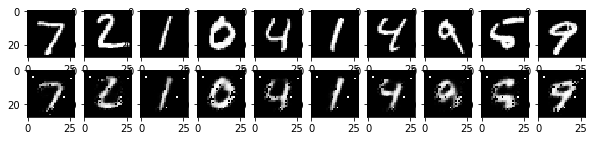

In [22]:
model = Autoencoder( n_features=28*28,
                     learning_rate= 0.01,
                     n_hidden=[256,128],
                     alpha=0.0,
                    )
model.fit(X=train_data.images,
          epochs=10,
          validation_data=(valid_data.images),
          test_data=(test_data.images),
          batch_size = 256,
         )

fig, axis = plt.subplots(2, 10, figsize=(10, 2))
for i in range(0,10):
    img_original = np.reshape(test_data.images[i],(28,28))
    axis[0][i].imshow(img_original, cmap='gray')
    img = np.reshape(model.predict(test_data.images[i]),(28,28))
    axis[1][i].imshow(img, cmap='gray')
plt.show()

Epoch  1/10: 
[55000/55000] loss =    0.0464 , val_loss =    0.0522
Epoch  2/10: 
[55000/55000] loss =    0.0321 , val_loss =    0.0429
Epoch  3/10: 
[55000/55000] loss =    0.0243 , val_loss =    0.0329
Epoch  4/10: 
[55000/55000] loss =    0.0188 , val_loss =    0.0269
Epoch  5/10: 
[55000/55000] loss =    0.0159 , val_loss =    0.0261
Epoch  6/10: 
[55000/55000] loss =    0.0134 , val_loss =    0.0232
Epoch  7/10: 
[55000/55000] loss =    0.0111 , val_loss =    0.0198
Epoch  8/10: 
[55000/55000] loss =    0.0092 , val_loss =    0.0158
Epoch  9/10: 
[55000/55000] loss =    0.0083 , val_loss =    0.0157
Epoch 10/10: 
[55000/55000] loss =    0.0074 , val_loss =    0.0134
test_loss =    0.0032


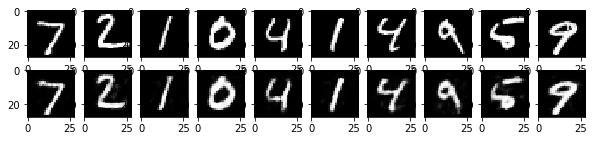

In [23]:
model2 = Autoencoder( n_features=28*28,
                     learning_rate= 0.01,
                     n_hidden=[256,128],
                     alpha=0.1,
                    )
model2.fit(X=train_data.images,
          epochs=10,
          validation_data=(valid_data.images),
          test_data=(test_data.images),
          batch_size = 256,
         )

fig, axis = plt.subplots(2, 10, figsize=(10, 2))
for i in range(0,10):
    img_original = np.reshape(test_data.images[i],(28,28))
    axis[0][i].imshow(img_original, cmap='gray')
    img = np.reshape(model2.predict(test_data.images[i]),(28,28))
    axis[1][i].imshow(img, cmap='gray')
plt.show()